## Visualization of One Election 
#### It performs MDS on the data and outputs the candidates and voters positions on a single axis 


In [1]:
import seaborn as sns

from scipy.stats import kurtosis, skew

from rcv_distribution import *
from MDS_analysis import *
from voting_rules import *
from consistency import *

##### Assign csv to the path of the file you are wishing to analyse

c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\cleaned files\MDS_analysis.py:162: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Golden, Jared F.': 0.0, 'St. Clair, Lucas R.': 0.694228146564781, 'Olson, Craig R.': 1.7932149099284096, 'Fulford, Jonathan S.': 3.0}


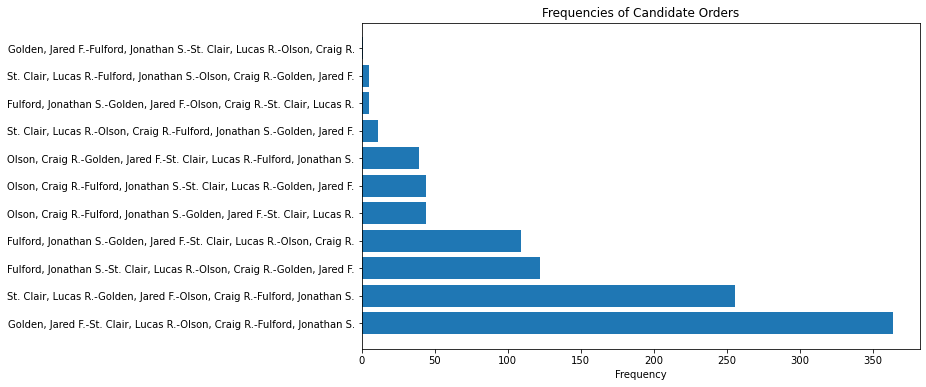

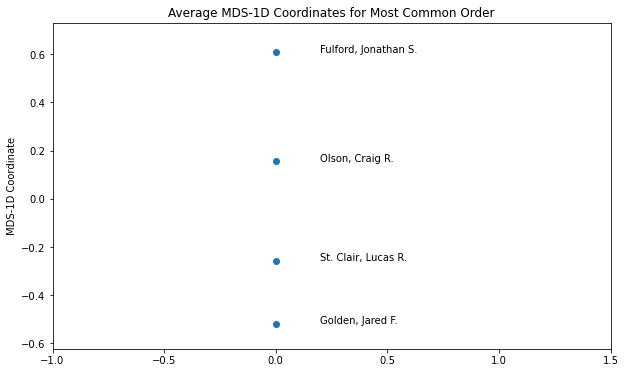

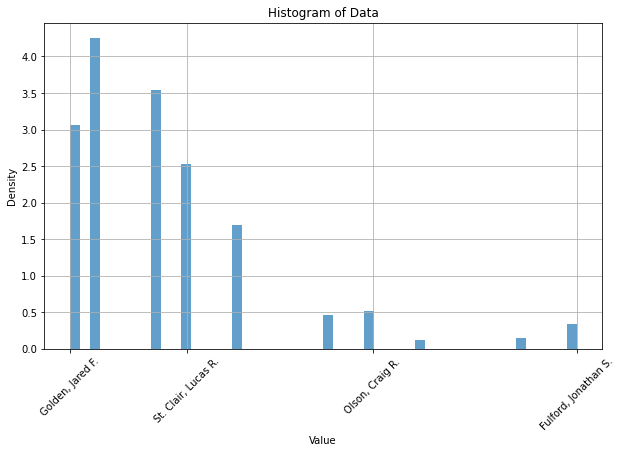

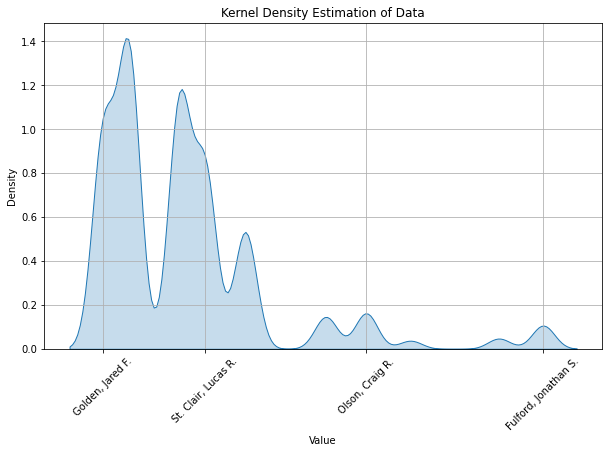

In [16]:
# Test the function with a custom CSV file
csv = "dataverse_files/Maine_06122018_DemocraticPrimaryforCD2.csv"

ballots, candidates = parse_election_data(csv)

# Perform the RCV analysis
test = perform_rcv_analysis(ballots, candidates, n_runs=1000, metric=False)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances)
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(ballots, candidates, normalized_distances)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

normalized_points = []
normalized_names = []
for name in normalized_distances:
    normalized_names.append(name)
    normalized_points.append(normalized_distances[name])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


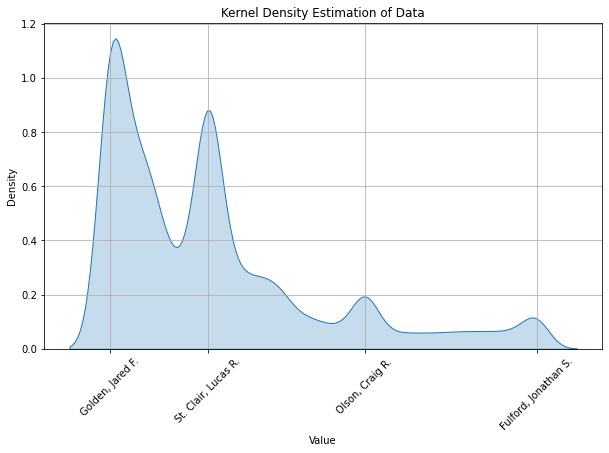

In [2]:
normalized_distances = {'Golden, Jared F.': 0.0, 'St. Clair, Lucas R.': 0.694228146564781, 'Olson, Craig R.': 1.7932149099284096, 'Fulford, Jonathan S.': 3.0}
csv = "dataverse_files/Maine_06122018_DemocraticPrimaryforCD2.csv"
ballots, candidates = parse_election_data(csv)

plot_KDE(ballots, normalized_distances)

#### run this cell to see the bimodality and gamma indices

In [6]:
#ballots, candidates = parse_election_data(csv)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate bimodality coefficient
n = len(data_points)
bimodality = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))
print("Bimodality coefficient:", bimodality)
print("Permissive Gamma coefficiet:", get_permissive_gamma(ballots, normalized_distances)[1])
print("Strict Gamma coefficiet:", get_strict_gamma(ballots, normalized_distances))



Bimodality coefficient: 0.912590212037788
Permissive Gamma coefficiet: 0.8437871576328024
Strict Gamma coefficiet: 0.8033906716893734


#### winner under different RCV methods 

In [4]:

election = voting_rules(ballots, candidates)
print("IRV: ", election.irv())
print("Condorcet: ", election.condorcet())
print("Black: ", election.black())
print("Borda: ", election.borda())
print("Bucklin: ", election.bucklin())
print("Ranked Pairs: ", election.ranked_pairs())
print("Copeland: ", election.copeland())
print("mini_max: ", election.mini_max())
print("Plurality: ", election.plurality())
print("Majority: ", election.majority())
print("Approval: ", election.approval())

IRV:  DEM Golden, Jared F.
Condorcet:  DEM Golden, Jared F.
Black:  DEM Golden, Jared F.
Borda:  DEM Golden, Jared F.
Bucklin:  DEM Golden, Jared F.
Ranked Pairs:  DEM Golden, Jared F.
Copeland:  DEM Golden, Jared F.
mini_max:  DEM Golden, Jared F.
Plurality:  REP Poliquin, Bruce
Majority:  -1
Approval:  DEM Golden, Jared F.


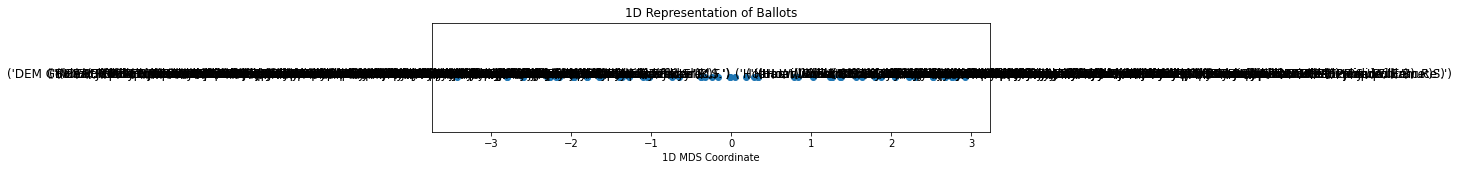

In [12]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Sample ballots
"""ballots = {
    ('A', 'B', 'D'): 123, 
    ('B', 'C'): 342, 
    ('A', 'C', 'B'): 543, 
    ('D', 'C'): 102, 
    ('A',): 233,
    ('C', 'D',): 28
}"""

csv = "dataverse_files/Maine_11062018_CongressionalDistrict2.csv"

ballots, candidates = parse_election_data(csv)

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Represent each ballot as a vector
def ballot_to_vector(ballot, candidates):
    vector = []
    for candidate in candidates:
        if candidate in ballot:
            vector.append(ballot.index(candidate))
        else:
            vector.append(len(ballot))  # A large number indicating the candidate is not ranked
    return vector

ballot_vectors = np.array([ballot_to_vector(ballot, candidates) for ballot in ballots.keys()])

# Step 3: Compute the pairwise distance matrix
# Here we use the Euclidean distance
distance_matrix = pairwise_distances(ballot_vectors, metric='euclidean')

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
ballot_1d = mds.fit_transform(distance_matrix)

# Output the result
result = dict(zip(ballots.keys(), ballot_1d.flatten()))

# Visualize the result
plt.figure(figsize=(10, 2))
y = np.zeros_like(list(result.values()))
plt.scatter(list(result.values()), y)

for ballot, x in result.items():
    plt.text(x, 0, str(ballot), fontsize=12, ha='right' if x < 0 else 'left')
    
plt.title("1D Representation of Ballots")
plt.yticks([])
plt.xlabel("1D MDS Coordinate")
plt.show()


In [18]:
csv = "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"

ballots, candidates = parse_election_data(csv)

('Peltola, Mary S.', 'Begich, Nick')   0.014389841641814812
('Peltola, Mary S.',)   0.3085852935768789
('Peltola, Mary S.', 'Begich, Nick', 'Palin, Sarah')   0.31501971510703985
('Palin, Sarah',)   0.0791817981770008
('Begich, Nick', 'Palin, Sarah', 'Peltola, Mary S.')   -0.4002610041209972
('Begich, Nick',)   -0.5173706983816989
('Begich, Nick', 'Peltola, Mary S.', 'Palin, Sarah')   -0.5519680273317864
('Peltola, Mary S.', 'Palin, Sarah', 'Begich, Nick')   0.5873094552399905
('Palin, Sarah', 'Begich, Nick')   0.10343096359153776
('Palin, Sarah', 'Begich, Nick', 'Peltola, Mary S.')   0.16339547967264356
('Begich, Nick', 'Peltola, Mary S.')   -0.6715889382141621
('Begich, Nick', 'Palin, Sarah')   0.8166428135326275
('Peltola, Mary S.', 'Palin, Sarah')   0.5778773665860846
('Palin, Sarah', 'Peltola, Mary S.', 'Begich, Nick')   -0.4772098503209551
('Palin, Sarah', 'Peltola, Mary S.')   -0.5349473247336038


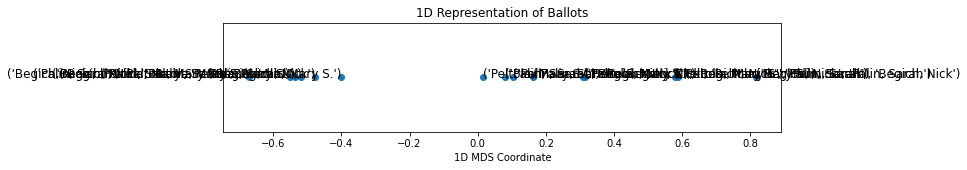

'from sklearn.neighbors import KernelDensity\nkde = KernelDensity(kernel=\'gaussian\', bandwidth=0.1).fit(ballot_positions[:, None])\n\n# Create a grid to evaluate the density\nx_grid = np.linspace(ballot_positions.min() - 1, ballot_positions.max() + 1, 1000)[:, None]\nlog_density = kde.score_samples(x_grid)\ndensity = np.exp(log_density)\n\n# Step 6: Assign each candidate a point based on the density distribution\ncandidate_points = {}\nfor candidate in candidates:\n    candidate_indices = [i for i, ballot in enumerate(result.keys()) if candidate in ballot]\n    candidate_positions = ballot_positions[candidate_indices]\n    if candidate_positions.size > 0:\n        kde_candidate = KernelDensity(kernel=\'gaussian\', bandwidth=0.1).fit(candidate_positions[:, None])\n        log_density_candidate = kde_candidate.score_samples(x_grid)\n        density_candidate = np.exp(log_density_candidate)\n        # Find the position of the peak density for the candidate\n        candidate_point = x_g

In [21]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from itertools import permutations

# Sample ballots

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
"""def permutation_distance(perm1, perm2):
    # Create a mapping of candidate to position for each permutation
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    # Compute the distance based on Kendall Tau logic with adjustments for missing candidates
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance
    """

n = len(candidates)

def permutation_distance(perm1, perm2):
    distance = 0
    for i in range(min(len(perm1), len(perm2))):
        if (perm1[i] != perm2[i]):
            distance += 2 ** (n - i -1)
        #print(perm1, "   ", perm2, " ", distance)
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
for b in ballot_list:
    if (len(b) == 0):
        ballot_list.remove(b)
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42, metric=False)
ballot_1d = mds.fit_transform(distance_matrix)

# Output the result
result = dict(zip(ballot_list, ballot_1d.flatten()))

# Flatten the ballot positions
ballot_positions = np.array(list(result.values()))
for b in result:
    print(b, " ", result[b])



plt.figure(figsize=(10, 2))
y = np.zeros_like(list(result.values()))
plt.scatter(list(result.values()), y)

for ballot, x in result.items():
    plt.text(x, 0, str(ballot), fontsize=12, ha='right' if x < 0 else 'left')
    
plt.title("1D Representation of Ballots")
plt.yticks([])
plt.xlabel("1D MDS Coordinate")
plt.show()

# Step 5: Evaluate the density using Kernel Density Estimation
"""from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(ballot_positions[:, None])

# Create a grid to evaluate the density
x_grid = np.linspace(ballot_positions.min() - 1, ballot_positions.max() + 1, 1000)[:, None]
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Step 6: Assign each candidate a point based on the density distribution
candidate_points = {}
for candidate in candidates:
    candidate_indices = [i for i, ballot in enumerate(result.keys()) if candidate in ballot]
    candidate_positions = ballot_positions[candidate_indices]
    if candidate_positions.size > 0:
        kde_candidate = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(candidate_positions[:, None])
        log_density_candidate = kde_candidate.score_samples(x_grid)
        density_candidate = np.exp(log_density_candidate)
        # Find the position of the peak density for the candidate
        candidate_point = x_grid[np.argmax(density_candidate)]
        candidate_points[candidate] = candidate_point[0]

# Visualize the results
plt.figure(figsize=(12, 6))
#plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    point *= 100
    print(candidate, " ", point)
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.legend()
plt.show()"""


Bond, Tiffany L.   24.292438208587175
DEM Golden, Jared F.   22.1854531831311
Hoar, William R.S.   20.499865162766227
REP Poliquin, Bruce   19.23567414749261


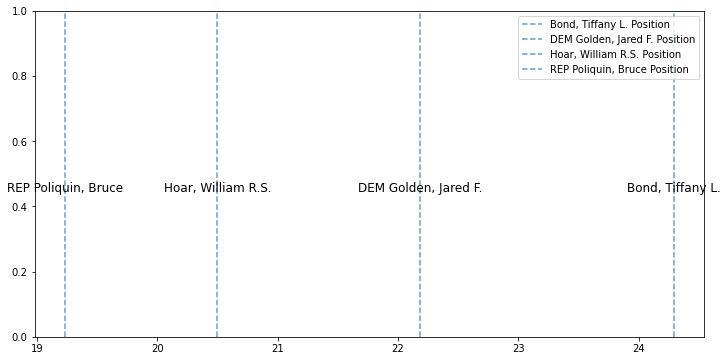

In [22]:
plt.figure(figsize=(12, 6))
#plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    point *= 100
    print(candidate, " ", point)
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.legend()
plt.show()

Begich, Nick   -41.32631506032638
Palin, Sarah   69.19796944184581
Peltola, Mary S.   10.663726662734874


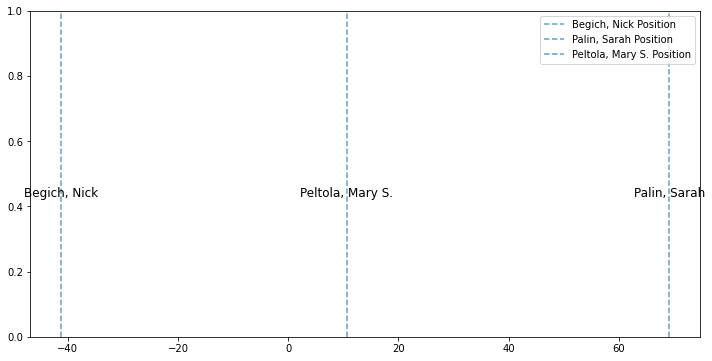

In [25]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import squareform
from collections import Counter
import matplotlib.pyplot as plt

# Sample ballots
csv = "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"

ballots, candidates = parse_election_data(csv)

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
def permutation_distance(perm1, perm2):
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Step 4: Run the MDS process 1000 times
results = []
for _ in range(1000):
    mds = MDS(n_components=1, dissimilarity='precomputed', metric=False)
    ballot_1d = mds.fit_transform(distance_matrix)
    result = tuple(ballot_1d.flatten())
    results.append(result)

# Step 5: Determine the most frequently occurring result
most_common_result = Counter(results).most_common(1)[0][0]

# Step 6: Evaluate the density using Kernel Density Estimation for the most common result
ballot_positions = np.array(most_common_result)

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(ballot_positions[:, None])

# Create a grid to evaluate the density
x_grid = np.linspace(ballot_positions.min() - 1, ballot_positions.max() + 1, 1000)[:, None]
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Step 7: Assign each candidate a point based on the density distribution
candidate_points = {}
for candidate in candidates:
    candidate_indices = [i for i, ballot in enumerate(ballot_list) if candidate in ballot]
    candidate_positions = ballot_positions[candidate_indices]
    if candidate_positions.size > 0:
        kde_candidate = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(candidate_positions[:, None])
        log_density_candidate = kde_candidate.score_samples(x_grid)
        density_candidate = np.exp(log_density_candidate)
        candidate_point = x_grid[np.argmax(density_candidate)]
        candidate_points[candidate] = candidate_point[0]

# Visualize the results
plt.figure(figsize=(12, 6))
#plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    point *= 100
    print(candidate, " ", point)
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.legend()
plt.show()


In [29]:
csv = "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"

ballots, candidates = parse_election_data(csv)

In [35]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import euclidean
from collections import Counter
import matplotlib.pyplot as plt
# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Extract the first-choice candidates from each ballot
first_choice_positions = []
for ballot in ballots.keys():
    first_choice_positions.append([ballot.index(candidate) if candidate in ballot else float('inf') for candidate in candidates])

# Step 3: Run the MDS process 1000 times
first_choice_positions = np.array(first_choice_positions)
euclidean_distance_matrix = np.zeros((len(ballots), len(ballots)))

for i in range(len(ballots)):
    for j in range(i + 1, len(ballots)):
        euclidean_distance_matrix[i, j] = euclidean(first_choice_positions[i], first_choice_positions[j])
        euclidean_distance_matrix[j, i] = euclidean_distance_matrix[i, j]

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
ballot_1d = mds.fit_transform(euclidean_distance_matrix)

# Step 5: Evaluate the density using Kernel Density Estimation
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(ballot_1d)

# Create a grid to evaluate the density
x_grid = np.linspace(ballot_1d.min() - 1, ballot_1d.max() + 1, 1000).reshape(-1, 1)
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Step 6: Assign each candidate a point based on the density distribution
candidate_points = {}
for candidate in candidates:
    candidate_indices = [i for i, ballot in enumerate(ballots.keys()) if candidate in ballot]
    candidate_positions = ballot_1d[candidate_indices]
    if candidate_positions.size > 0:
        kde_candidate = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(candidate_positions)
        log_density_candidate = kde_candidate.score_samples(x_grid)
        density_candidate = np.exp(log_density_candidate)
        candidate_point = x_grid[np.argmax(density_candidate)]
        candidate_points[candidate] = candidate_point[0]

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.scatter(ballot_1d, np.zeros_like(ballot_1d), color='red')
plt.title("Density of First-Choice Candidates on 1D MDS Axis (Euclidean Distance)")
plt.xlabel("1D MDS Coordinate")
plt.legend()
plt.show()

c:\Users\mahsh\anaconda3\lib\site-packages\scipy\spatial\distance.py:488: RuntimeWarning: invalid value encountered in subtract
  u_v = u - v


ValueError: array must not contain infs or NaNs

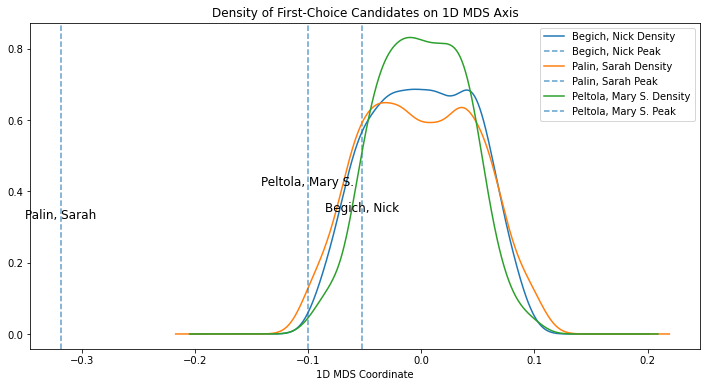

In [33]:
plt.figure(figsize=(12, 6))
for candidate, (x_grid, density) in first_choice_density.items():
    plt.plot(x_grid*0.1, density, label=f'{candidate} Density')
    max_density_pos = x_grid[np.argmax(density)]
    plt.axvline(max_density_pos, linestyle='--', label=f'{candidate} Peak', alpha=0.7)
    plt.text(max_density_pos, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.title("Density of First-Choice Candidates on 1D MDS Axis")
plt.xlabel("1D MDS Coordinate")
plt.legend()
plt.show()